In [2]:
# import libs
import glob, pylab, pandas as pd
import pydicom, numpy as np
import random
import json
import time
import copy
import pydicom
import torchvision
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
from torch.autograd import Variable
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F

from matplotlib import patches, patheffects

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from pathlib import Path


In [3]:
PATH = Path('../input')
class_df = pd.read_csv(PATH/'labels.csv')
class_df.head()
class_to_idx = {x:i for i,x in enumerate(class_df.breed.unique())}
idx_to_class = {i:x for i,x in enumerate(class_df.breed.unique())}
device = torch.cuda.set_device(0)

We create some helper func to load & show images
We implement Dataset class to load and give image. We are centering the odd resized image and pasting on black background.

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
  o.set_path_effects([patheffects.Stroke(
      linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def black_background_thumbnail(image, thumbnail_size=(224,224)):
    background = Image.new('RGB', thumbnail_size, "black")    
    source_image = image.convert("RGB")
    source_image.thumbnail(thumbnail_size)
    (w, h) = source_image.size
    background.paste(source_image, (int((thumbnail_size[0] - w) / 2), int((thumbnail_size[1] - h) / 2) ))
    return background

class CDataset(Dataset):
    def __init__(self, ds, img_dir, class_df, class_to_idx, transform=None,): 
        self.ds = ds
        self.img_dir = img_dir
        self.class_df = class_df
        self.class_to_idx = class_to_idx
        self.transform = transform if transform else None
        
    def __len__(self): 
        return len(self.ds)
    
    def read_image(self, loc):
        img_arr = Image.open(loc.as_posix())
        return img_arr.convert('RGB')
        
    def __getitem__(self, i):
        img = self.read_image(self.ds[i])
        img = black_background_thumbnail(img)
        if self.transform:
            img = self.transform(img)
        label = self.ds[i].name.split('.')[0]
        kls = self.class_df[self.class_df['id'] == label]
        return img, self.class_to_idx[kls.iloc[0].breed]

https://github.com/pytorch/vision/blob/master/torchvision/utils.py

In [12]:
img_dir = PATH/'train'
sample = list(img_dir.iterdir())
train, test = train_test_split(sample)
batch_size=32
sz=224

# if adding normalize with given value will cause transformed image range value in -ve to +ve.
# avoid it.
transform = transforms.Compose([
        transforms.CenterCrop(sz),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
#         transforms.FiveCrop(sz),
        transforms.RandomVerticalFlip(),
#         transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))
#         transforms.ColorJitter(brightness=5, contrast=1, saturation=0, hue=0),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_ds = CDataset(train, img_dir, class_df, class_to_idx, transform=transform)
test_ds = CDataset(test, img_dir, class_df, class_to_idx, transform=transform)
train_dl = DataLoader(train_ds, batch_size=batch_size,)
test_dl = DataLoader(test_ds, batch_size=batch_size,)

In [13]:
len(train)

7666

In [14]:
len(train_ds)

7666

Lets plot some images

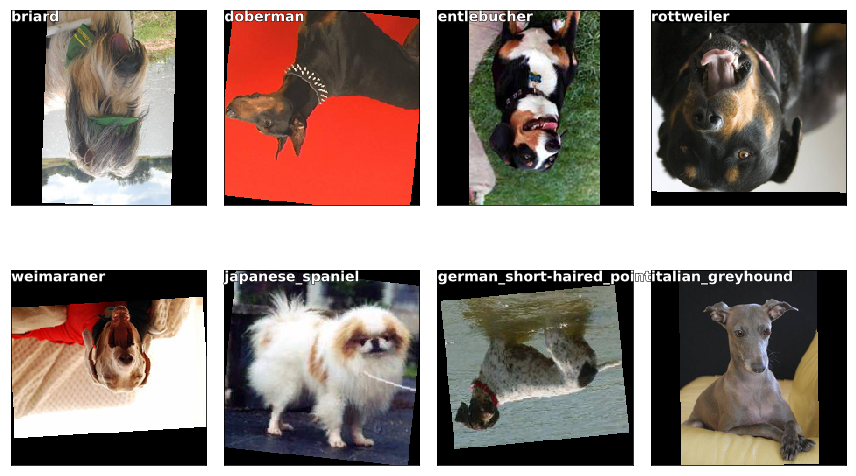

In [15]:
image, klass = next(iter(train_dl))
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=image[i].numpy().transpose((1, 2, 0))
    b = idx_to_class[klass[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

Lets create a trainer

In [16]:
loss_train_history = []
loss_val_history = []
acc_train_history = []
acc_val_history = []

In [ ]:
torch.nn.functional.softmax

In [24]:
use_gpu = torch.cuda.is_available()
dataloaders = {'train': train_dl, 'val':test_dl}
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        start = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            data_loader = dataloaders[phase]
            for data in tqdm_notebook(data_loader):
                # get the inputs
                inputs, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(),)
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs = torch.nn.functional.softmax(model(inputs), dim=1)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects / len(data_loader.dataset)
            if phase == 'train':
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc)
            else:
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc)
            epoch_time = time.time() - start
            tqdm.write('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, epoch_time // 60, epoch_time % 60))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        tqdm.write('')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = torchvision.models.resnet152(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_to_idx))
model_ft = model_ft.cuda(0)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.plot(b, label='val')
plt.plot(a, label='train')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('resnet152')
plt.legend(loc='upper right')

plt.show()

In [ ]:
plt.plot(d, label='val')
plt.plot(c, label='train')

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('resnet152')
plt.legend(loc='lower right')

plt.show()

In [ ]:
a = loss_train_history
b = loss_val_history 
c = acc_train_history 
d = acc_val_history 

I stopped because validation accuracy is not improving. 

In [ ]:
loss_train_history = []
loss_val_history = []
acc_train_history = []
acc_val_history = []

In [ ]:
model_18 = torchvision.models.resnet18(pretrained=True)
for param in model_18.parameters():
    param.requires_grad = False

num_ftrs = model_18.fc.in_features
model_18.fc = nn.Linear(num_ftrs, len(class_to_idx))
model_18 = model_18.cuda(0)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_18.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_18 = train_model(model_18, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

In [ ]:
plt.plot(loss_val_history, label='val')
plt.plot(loss_train_history, label='train')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('resnet18')
plt.legend(loc='upper right')

plt.show()

In [ ]:
plt.plot(acc_val_history, label='val')
plt.plot(acc_train_history, label='train')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('resnet18')
plt.legend(loc='lower right')

plt.show()

In [18]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)

        self.fc1 = nn.Linear(256 * 6 * 6, 120)
        
        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        self.dropout = nn.Dropout(0.2)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv_bn2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = self.conv_bn3(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = self.conv_bn4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv4(x)
        x = self.conv_bn5(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = self.conv_bn6(x)
        x = F.relu(x)
        x = self.max_pool(x)
        
        x = self.dropout(x)
        
        x = x.view(-1, 256 * 6 * 6)
        
        x = self.fc1(x)


        return x

# instantiate the CNN
model_scratch = Net()

In [25]:
model_ft = model_scratch.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7000, gamma=0.5)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

A Jupyter Widget

  0%|          | 0/15 [01:35<?, ?it/s]

train Loss: 4.6617 Acc: 0.1561 in 1m 36s


A Jupyter Widget

  7%|▋         | 1/15 [02:06<29:32, 126.60s/it]

val Loss: 4.7206 Acc: 0.0829 in 2m 7s



A Jupyter Widget

  7%|▋         | 1/15 [03:42<52:00, 222.92s/it]

train Loss: 4.6250 Acc: 0.1910 in 1m 36s


A Jupyter Widget

 13%|█▎        | 2/15 [04:13<27:27, 126.75s/it]

val Loss: 4.7143 Acc: 0.0908 in 2m 7s



A Jupyter Widget

 13%|█▎        | 2/15 [05:50<37:56, 175.10s/it]

train Loss: 4.6070 Acc: 0.2056 in 1m 37s


A Jupyter Widget

 20%|██        | 3/15 [06:20<25:22, 126.88s/it]

val Loss: 4.7181 Acc: 0.0861 in 2m 7s



A Jupyter Widget

 20%|██        | 3/15 [07:57<31:49, 159.11s/it]

train Loss: 4.5872 Acc: 0.2272 in 1m 37s


A Jupyter Widget

 27%|██▋       | 4/15 [08:27<23:16, 126.94s/it]

val Loss: 4.7223 Acc: 0.0806 in 2m 7s



A Jupyter Widget

 27%|██▋       | 4/15 [10:04<27:42, 151.14s/it]

train Loss: 4.5778 Acc: 0.2362 in 1m 37s


A Jupyter Widget

 33%|███▎      | 5/15 [10:35<21:10, 127.03s/it]

val Loss: 4.7232 Acc: 0.0763 in 2m 7s



A Jupyter Widget

 33%|███▎      | 5/15 [12:12<24:24, 146.44s/it]

train Loss: 4.5614 Acc: 0.2520 in 1m 37s


A Jupyter Widget

 40%|████      | 6/15 [12:43<19:05, 127.24s/it]

val Loss: 4.7075 Acc: 0.0919 in 2m 8s



A Jupyter Widget

 40%|████      | 6/15 [14:19<21:29, 143.32s/it]

train Loss: 4.5449 Acc: 0.2681 in 1m 36s


A Jupyter Widget

 47%|████▋     | 7/15 [14:51<16:58, 127.33s/it]

val Loss: 4.7273 Acc: 0.0720 in 2m 8s



A Jupyter Widget

 47%|████▋     | 7/15 [16:27<18:48, 141.07s/it]

train Loss: 4.5073 Acc: 0.3029 in 1m 36s


A Jupyter Widget

 53%|█████▎    | 8/15 [16:59<14:51, 127.38s/it]

val Loss: 4.7145 Acc: 0.0849 in 2m 8s



A Jupyter Widget

 53%|█████▎    | 8/15 [18:36<16:16, 139.52s/it]

train Loss: 4.4946 Acc: 0.3180 in 1m 37s


A Jupyter Widget

 60%|██████    | 9/15 [19:07<12:45, 127.50s/it]

val Loss: 4.6927 Acc: 0.1084 in 2m 8s



A Jupyter Widget

 60%|██████    | 9/15 [20:45<13:50, 138.33s/it]

train Loss: 4.4772 Acc: 0.3358 in 1m 38s


A Jupyter Widget

 67%|██████▋   | 10/15 [21:15<10:37, 127.57s/it]

val Loss: 4.7117 Acc: 0.0900 in 2m 8s



A Jupyter Widget

 67%|██████▋   | 10/15 [22:52<11:26, 137.25s/it]

train Loss: 4.4757 Acc: 0.3347 in 1m 37s


A Jupyter Widget

 73%|███████▎  | 11/15 [23:22<08:30, 127.52s/it]

val Loss: 4.7008 Acc: 0.1025 in 2m 7s



A Jupyter Widget

 73%|███████▎  | 11/15 [24:59<09:05, 136.31s/it]

train Loss: 4.4553 Acc: 0.3600 in 1m 37s


A Jupyter Widget

 80%|████████  | 12/15 [25:29<06:22, 127.49s/it]

val Loss: 4.6832 Acc: 0.1201 in 2m 7s



A Jupyter Widget

 80%|████████  | 12/15 [27:06<06:46, 135.58s/it]

train Loss: 4.4482 Acc: 0.3655 in 1m 37s


A Jupyter Widget

 87%|████████▋ | 13/15 [27:38<04:15, 127.54s/it]

val Loss: 4.6775 Acc: 0.1307 in 2m 8s



A Jupyter Widget

 87%|████████▋ | 13/15 [29:14<04:29, 134.99s/it]

train Loss: 4.4352 Acc: 0.3804 in 1m 37s


A Jupyter Widget

 93%|█████████▎| 14/15 [29:45<02:07, 127.57s/it]

val Loss: 4.6781 Acc: 0.1225 in 2m 8s



A Jupyter Widget

 93%|█████████▎| 14/15 [31:22<02:14, 134.46s/it]

train Loss: 4.4199 Acc: 0.3937 in 1m 37s


A Jupyter Widget

100%|██████████| 15/15 [31:54<00:00, 127.61s/it]

val Loss: 4.6711 Acc: 0.1373 in 2m 8s

Training complete in 31m 54s
Best val Acc: 0.137324


In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

A Jupyter Widget

  0%|          | 0/15 [01:36<?, ?it/s]

train Loss: 4.4085 Acc: 0.4054 in 1m 37s


A Jupyter Widget

  7%|▋         | 1/15 [02:08<29:56, 128.33s/it]

val Loss: 4.6746 Acc: 0.1311 in 2m 8s



A Jupyter Widget

  7%|▋         | 1/15 [03:45<52:37, 225.56s/it]

train Loss: 4.4033 Acc: 0.4113 in 1m 37s


A Jupyter Widget

 13%|█▎        | 2/15 [04:16<27:46, 128.23s/it]

val Loss: 4.6775 Acc: 0.1291 in 2m 8s



A Jupyter Widget

 13%|█▎        | 2/15 [05:53<38:19, 176.89s/it]

train Loss: 4.3962 Acc: 0.4172 in 1m 37s


A Jupyter Widget

 20%|██        | 3/15 [06:24<25:37, 128.15s/it]

val Loss: 4.6746 Acc: 0.1322 in 2m 8s



A Jupyter Widget

 20%|██        | 3/15 [08:01<32:05, 160.44s/it]

train Loss: 4.3928 Acc: 0.4223 in 1m 37s


A Jupyter Widget

 27%|██▋       | 4/15 [08:32<23:28, 128.00s/it]

val Loss: 4.6717 Acc: 0.1354 in 2m 8s



A Jupyter Widget

 27%|██▋       | 4/15 [10:09<27:55, 152.30s/it]

train Loss: 4.3869 Acc: 0.4273 in 1m 37s


A Jupyter Widget

 33%|███▎      | 5/15 [10:40<21:20, 128.04s/it]

val Loss: 4.6791 Acc: 0.1248 in 2m 8s



A Jupyter Widget

 33%|███▎      | 5/15 [12:17<24:34, 147.44s/it]

train Loss: 4.3827 Acc: 0.4324 in 1m 37s


A Jupyter Widget

 40%|████      | 6/15 [12:48<19:12, 128.02s/it]

val Loss: 4.6810 Acc: 0.1232 in 2m 8s



A Jupyter Widget

 40%|████      | 6/15 [14:26<21:39, 144.40s/it]

train Loss: 4.3682 Acc: 0.4485 in 1m 38s


A Jupyter Widget

 47%|████▋     | 7/15 [14:59<17:07, 128.50s/it]

val Loss: 4.6674 Acc: 0.1416 in 2m 11s



A Jupyter Widget

 47%|████▋     | 7/15 [16:40<19:02, 142.87s/it]

train Loss: 4.3681 Acc: 0.4477 in 1m 41s


A Jupyter Widget

 53%|█████▎    | 8/15 [17:12<15:03, 129.10s/it]

val Loss: 4.6695 Acc: 0.1358 in 2m 13s



A Jupyter Widget

 53%|█████▎    | 8/15 [18:54<16:32, 141.77s/it]

train Loss: 4.3611 Acc: 0.4529 in 1m 41s


A Jupyter Widget

 60%|██████    | 9/15 [19:26<12:57, 129.61s/it]

val Loss: 4.6632 Acc: 0.1436 in 2m 14s



A Jupyter Widget

 60%|██████    | 9/15 [21:11<14:07, 141.30s/it]

train Loss: 4.3598 Acc: 0.4545 in 1m 45s


A Jupyter Widget

 67%|██████▋   | 10/15 [21:45<10:52, 130.53s/it]

val Loss: 4.6693 Acc: 0.1350 in 2m 19s



A Jupyter Widget

 67%|██████▋   | 10/15 [23:35<11:47, 141.58s/it]

train Loss: 4.3562 Acc: 0.4589 in 1m 50s


A Jupyter Widget

 73%|███████▎  | 11/15 [24:11<08:47, 131.99s/it]

val Loss: 4.6644 Acc: 0.1405 in 2m 26s



A Jupyter Widget

 73%|███████▎  | 11/15 [26:04<09:28, 142.21s/it]

train Loss: 4.3536 Acc: 0.4624 in 1m 52s


A Jupyter Widget

 80%|████████  | 12/15 [26:40<06:40, 133.34s/it]

val Loss: 4.6663 Acc: 0.1365 in 2m 28s



A Jupyter Widget

 80%|████████  | 12/15 [28:31<07:07, 142.64s/it]

train Loss: 4.3469 Acc: 0.4678 in 1m 52s


A Jupyter Widget

 87%|████████▋ | 13/15 [29:07<04:28, 134.45s/it]

val Loss: 4.6638 Acc: 0.1432 in 2m 28s



A Jupyter Widget

 87%|████████▋ | 13/15 [30:59<04:46, 143.03s/it]

train Loss: 4.3485 Acc: 0.4669 in 1m 52s


A Jupyter Widget

 93%|█████████▎| 14/15 [31:34<02:15, 135.30s/it]

val Loss: 4.6696 Acc: 0.1346 in 2m 26s



A Jupyter Widget

 93%|█████████▎| 14/15 [33:24<02:23, 143.19s/it]

train Loss: 4.3442 Acc: 0.4700 in 1m 51s


A Jupyter Widget

100%|██████████| 15/15 [34:00<00:00, 136.07s/it]

val Loss: 4.6639 Acc: 0.1420 in 2m 27s

Training complete in 34m 1s
Best val Acc: 0.143584


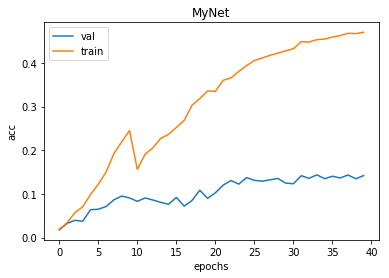

In [28]:
plt.plot(acc_val_history, label='val')
plt.plot(acc_train_history, label='train')

plt.xlabel("epochs")
plt.ylabel("acc")
plt.title('MyNet')
plt.legend(loc='upper left')

plt.show()

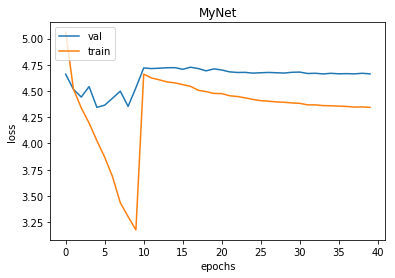

In [29]:
plt.plot(loss_val_history, label='val')
plt.plot(loss_train_history, label='train')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('MyNet')
plt.legend(loc='upper left')

plt.show()